## EDA and Classify using Embeddings

We want to evaluate embedding quality by seeing how well they can be used to classify the data. We will use the embeddings to train a classifier and see how well it performs.

In [1]:
import pandas as pd
import numpy as np
from utils import drug_data_tools

In [4]:
drug_classes = pd.read_csv("outputs/drug-classes.csv", index_col=0)#, index_col="Drug Name")
drug_classes

,Drug Class
Drug Name,
ella,Progesterone receptor modulators
pancreatin,Digestive enzymes
boroleum,Topical rubefacient
benicar,Angiotensin receptor blockers
duac,Topical acne agents
...,...
acne-10-gel-topical,Topical acne agents
lorbrena,Multikinase inhibitors
halcion,Benzodiazepines


In [5]:
selected_molecules = drug_data_tools.get_selected_molecules(filter_molecules=False)
len(selected_molecules)

5747

In [7]:
# Drugs that are both in Drugs.com (i.e. we have class information for) and Selected Molecules
len(set(drug_classes.index).intersection(selected_molecules))

629

In [8]:
# Select them out
selected_drugs_com_molecules = drug_classes[drug_classes.index.isin(set(drug_classes.index).intersection(selected_molecules))]
# intersecting_drugs

In [9]:
selected_drugs_com_molecules['Drug Class'].value_counts()

Drug Class
Multikinase inhibitors                      23
Nonsteroidal anti-inflammatory drugs        11
Angiotensin Converting Enzyme Inhibitors    11
Miscellaneous antineoplastics               11
Opioids (narcotic analgesics)               11
                                            ..
Estrogens                                    1
Methylxanthines                              1
Sterile irrigating solutions                 1
Diarylquinolines                             1
First generation cephalosporins              1
Name: count, Length: 220, dtype: int64

Filter out classes with less than 3 drugs in them

In [11]:
class_counts = selected_drugs_com_molecules["Drug Class"].value_counts()
selected_drugs_com_molecules = selected_drugs_com_molecules[~selected_drugs_com_molecules['Drug Class'].isin(class_counts[class_counts < 3].index)]

selected_drugs_com_molecules

,Drug Class
Drug Name,
paliperidone,Atypical antipsychotics
carboplatin,Alkylating agents
apraclonidine,Ophthalmic glaucoma agents
naproxen,Nonsteroidal anti-inflammatory drugs
fesoterodine,Urinary antispasmodics
...,...
ixazomib,Proteasome inhibitors
terbinafine,Miscellaneous antifungals
azithromycin,Macrolides


In [12]:
# Nr unique drug classes after filtering
len(set(selected_drugs_com_molecules['Drug Class']))

89

Load Llama embeddings of Selected Molecules. select out only intersecting ones

In [13]:
df_embeddings = pd.read_csv("outputs/llama-embeddings.csv", index_col=0)

In [14]:
# TODO Why are some drugs missing? 115 vs 103
intersecting_drugs_w_embd_df = df_embeddings.loc[df_embeddings.index.intersection(set(selected_drugs_com_molecules.index))]
intersecting_drugs_w_embd_df

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Drug Name,,,,,,,,,,,,,,,,,,,,,
natalizumab,2.828465,-0.323880,0.461534,1.198783,0.935547,0.000823,0.155675,-0.988050,-1.114025,-0.150321,...,0.569156,0.244178,1.626112,0.391793,-3.204831,2.612899,-0.117829,-0.720186,-1.816628,0.691926
candesartan,0.846399,-1.726462,0.906651,-1.306898,0.193972,0.240104,0.303152,-1.743013,-1.192302,-1.672895,...,0.621502,-0.167140,0.252433,0.113513,-1.079827,-0.638547,1.297506,0.620969,0.505722,-1.139408
pemigatinib,1.657495,-1.523324,0.316984,0.202013,-0.703365,0.021658,-1.032712,-1.622851,0.565182,-2.019764,...,0.295195,-0.309789,-1.277183,0.816564,-0.307367,1.484333,0.583064,0.173681,-1.643754,0.549972
telmisartan,1.801593,-2.129047,0.749666,-0.453170,0.827487,-0.062932,0.020983,-0.774632,-0.643007,-2.144073,...,0.582292,0.434012,0.108160,0.781245,-1.225841,0.251356,0.407616,0.496148,0.615039,-1.151465
fluvastatin,1.884299,-1.708703,1.452643,-3.322976,0.765282,0.389487,1.642352,-0.425322,-0.315836,-1.930144,...,-0.278033,-0.646324,0.640017,0.383189,-0.533273,-2.756398,1.953617,-1.458458,-0.056362,0.846975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nilotinib,1.601887,-1.431789,0.930513,-0.039980,-0.114913,0.170020,-0.495912,-0.666444,0.297700,-1.711444,...,-0.162860,-0.389524,-0.343951,0.675022,0.365671,1.148861,-0.634807,0.387918,-1.746806,0.730049
sofosbuvir,0.019505,0.669670,-2.041065,-2.784205,0.027118,0.313708,1.415276,-2.556959,-0.927886,0.875131,...,-0.203469,1.499896,0.643817,3.036791,0.464148,2.561702,0.132109,-0.862448,-2.124450,0.070136
darunavir,0.206294,-0.861255,-1.311981,-0.856387,2.775300,0.372177,2.384961,-0.891477,-0.670463,-0.338599,...,-0.455320,2.972468,1.895652,1.195464,-0.460290,2.032736,-2.124213,1.353184,-2.773972,-1.118577


Apply dimensionality reduction to embeddings to plot them

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

t_sneezed_data = tsne.fit_transform(intersecting_drugs_w_embd_df)

print(type(t_sneezed_data))
print(t_sneezed_data.shape)

<class 'numpy.ndarray'>
(90, 2)


In [17]:
def add_class_and_names(dim_red_numpy_arr):
    """
        Sklearn's dimensionality reduction methods return numpy arrays. Add the drug class and drug name to the numpy array.
    """
    dim_red_numpy_arr = pd.DataFrame(dim_red_numpy_arr, index=intersecting_drugs_w_embd_df.index)
    dim_red_numpy_arr = pd.concat([pd.DataFrame(dim_red_numpy_arr, index=intersecting_drugs_w_embd_df.index), selected_drugs_com_molecules.loc[intersecting_drugs_w_embd_df.index]['Drug Class']], axis=1)

    dim_red_numpy_arr['Drug Class'] = pd.Series(dim_red_numpy_arr['Drug Class'], dtype="category")

    return dim_red_numpy_arr

In [18]:
t_sneezed_data_classes = add_class_and_names(t_sneezed_data)
t_sneezed_data_classes.head()

,0,1,Drug Class
Drug Name,,,
natalizumab,-7.113386,5.572962,Selective immunosuppressants
candesartan,0.050586,2.708056,Angiotensin receptor blockers
pemigatinib,-4.938816,4.993330,Multikinase inhibitors
telmisartan,0.456465,3.128065,Angiotensin receptor blockers
fluvastatin,0.661835,5.217521,Statins


In [19]:
t_sneezed_data_classes.head()

,0,1,Drug Class
Drug Name,,,
natalizumab,-7.113386,5.572962,Selective immunosuppressants
candesartan,0.050586,2.708056,Angiotensin receptor blockers
pemigatinib,-4.938816,4.993330,Multikinase inhibitors
telmisartan,0.456465,3.128065,Angiotensin receptor blockers
fluvastatin,0.661835,5.217521,Statins


In [20]:
t_sneezed_data_classes.dtypes

0              float32
1              float32
Drug Class    category
dtype: object

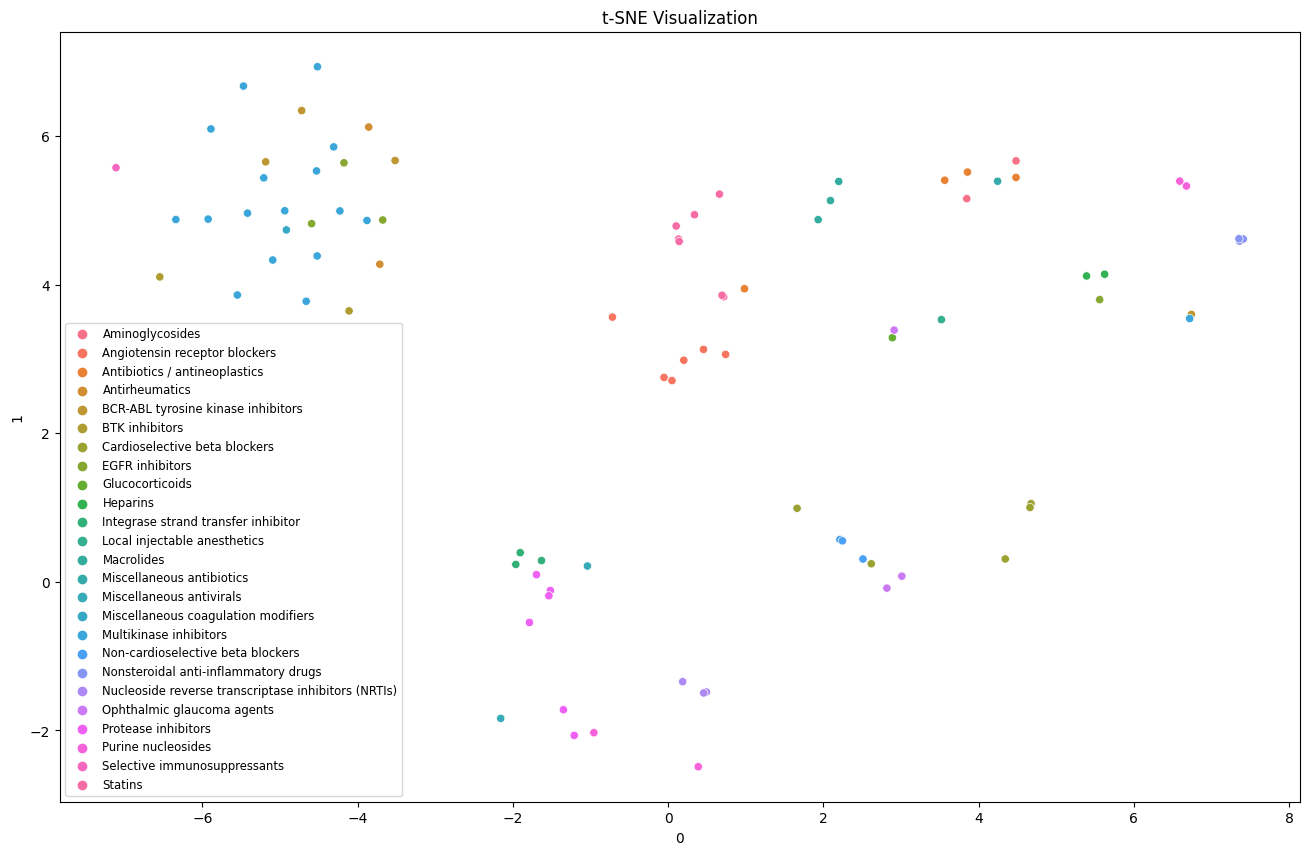

In [21]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=t_sneezed_data_classes.reset_index(drop=True), x=0, y=1, hue='Drug Class')


plt.title('t-SNE Visualization')
plt.legend(fontsize='small')
plt.show()

## Let's try 3D

In [22]:
tsne = TSNE(n_components=3, random_state=0)

t_sneezed_data = tsne.fit_transform(intersecting_drugs_w_embd_df)

print(type(t_sneezed_data))
print(t_sneezed_data.shape)

<class 'numpy.ndarray'>
(90, 3)


In [23]:
t_sneezed_data_classes = add_class_and_names(t_sneezed_data)

In [24]:
t_sneezed_data_classes.dtypes

0              float32
1              float32
2              float32
Drug Class    category
dtype: object

In [25]:
#change to widget for interactive
%matplotlib inline

In [26]:
def plot_interactive_3d(df_orig):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    df = df_orig.copy()

    cmap = plt.get_cmap("viridis")
    colors = cmap(np.linspace(0, 1, len(df["Drug Class"].cat.categories)))

    color_dict = dict(zip(df["Drug Class"].cat.categories, colors))

    df["Color"] = df["Drug Class"].cat.codes
    cmap = plt.cm.get_cmap("plasma", len(df["Drug Class"].cat.categories))

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Plot a 3D scatter plot
    sc = ax.scatter(df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], c=df["Color"], cmap=cmap)


    plt.show()

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_6487/3050845372.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("plasma", len(df["Drug Class"].cat.categories))


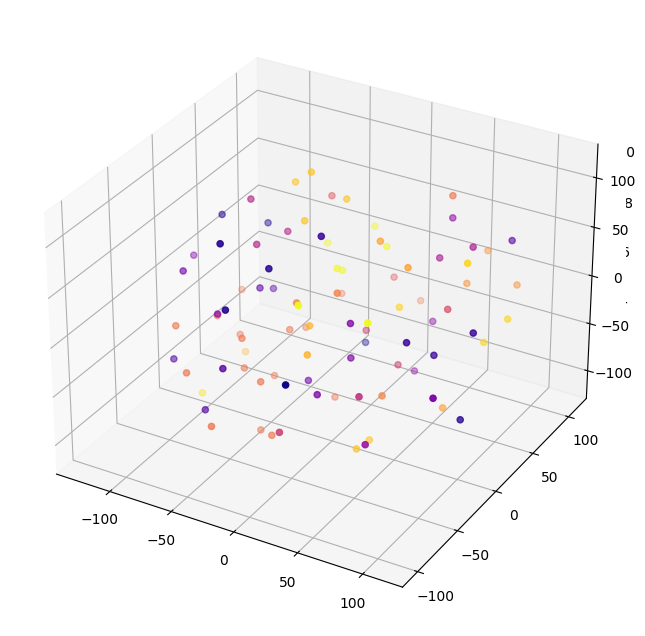

In [27]:
plot_interactive_3d(t_sneezed_data_classes)

## Let's perform Linear Discriminant Analysis to reduce the dimensionality of the embeddings, with the aim of classifying the drugs

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [29]:
lda = LDA(n_components=3)

lda_3d = lda.fit_transform(intersecting_drugs_w_embd_df, selected_drugs_com_molecules.loc[intersecting_drugs_w_embd_df.index]['Drug Class'])
lda_3d.shape

(90, 3)

In [30]:
lda_3d = add_class_and_names(lda_3d)

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_6487/3050845372.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("plasma", len(df["Drug Class"].cat.categories))


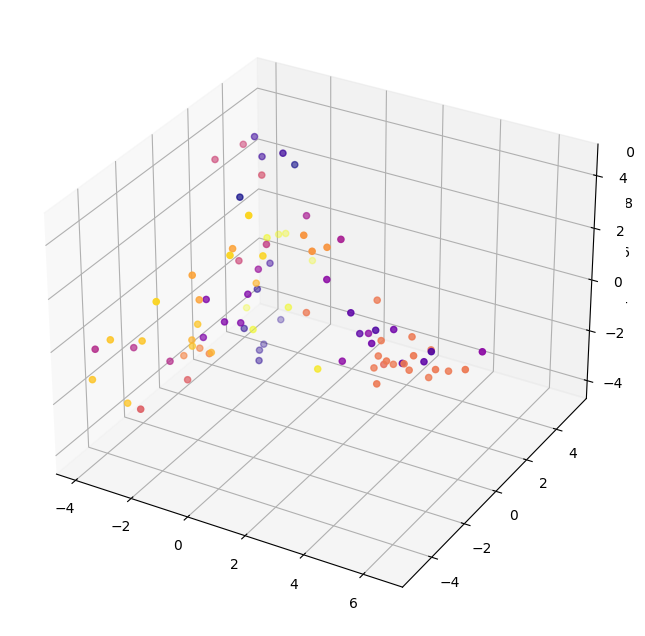

In [31]:
plot_interactive_3d(lda_3d)

## Let's classify using various methods to see performance

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [33]:
k = 5  # Number of folds

In [34]:
data = intersecting_drugs_w_embd_df
data['Drug Class'] = selected_drugs_com_molecules.loc[intersecting_drugs_w_embd_df.index]['Drug Class']
data.shape

(90, 4097)

In [35]:
%matplotlib inline

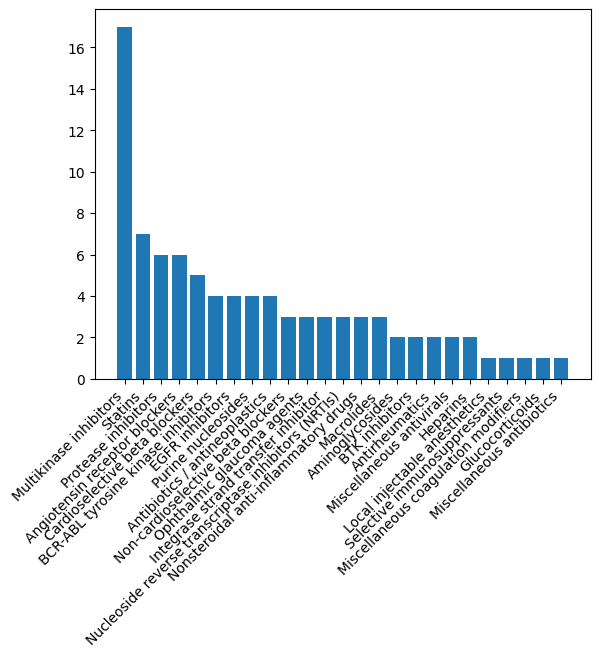

In [36]:
# Histogram of classes
plt.figure()

class_counts = data["Drug Class"].value_counts()
plt.bar(class_counts.index, class_counts.values)

# Rotate x-axis labels diagonally
plt.xticks(rotation=45, ha='right')

plt.show()


In [37]:
def run_cross_val(model, data):
    scores = cross_val_score(model, data.drop("Drug Class", axis=1), data['Drug Class'], cv=k)

    print("Cross-validation scores:", scores)

    mean_accuracy = np.mean(scores)
    print("Mean accuracy:", mean_accuracy)

No projection + Logistic Regression

In [38]:
run_cross_val(LogisticRegression(max_iter=1000), data)

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-validation scores: [0.44444444 0.72222222 0.66666667 0.72222222 0.61111111]
Mean accuracy: 0.6333333333333333


LDA - 3 components

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [40]:
a = LDA(n_components=3).fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])

run_cross_val(LDA(n_components=3), add_class_and_names(a))

Cross-validation scores: [0.33333333 0.38888889 0.44444444 0.5        0.38888889]
Mean accuracy: 0.4111111111111111


/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


LDA can not have more components than n_classes

In [41]:
a = LDA(n_components=15).fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])

run_cross_val(LDA(n_components=15), add_class_and_names(a))

Cross-validation scores: [0.27777778 0.55555556 0.66666667 0.61111111 0.55555556]
Mean accuracy: 0.5333333333333334


/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


<font color="orange">Interesting, by default LDA chooses fewer components than above?</font>

In [42]:
a = LDA().fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])

run_cross_val(LDA(), add_class_and_names(a))

Cross-validation scores: [0.22222222 0.38888889 0.38888889 0.5        0.38888889]
Mean accuracy: 0.37777777777777777


/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


TSNE (3 components) + Logistic Regression

In [43]:
from sklearn.manifold import TSNE

In [44]:
tsne = TSNE(n_components=3, random_state=0)
t_sneezed_data = tsne.fit_transform(data.drop("Drug Class", axis=1))

run_cross_val(LogisticRegression(max_iter=15000), add_class_and_names(t_sneezed_data))

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.22222222 0.22222222 0.27777778 0.27777778 0.27777778]
Mean accuracy: 0.25555555555555554


<font color="orange">TSNE(n_components=3) seems horrible, try PCA</font>

In [45]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=3)
pcad_data = pca.fit_transform(data.drop("Drug Class", axis=1))

run_cross_val(LogisticRegression(max_iter=15000), add_class_and_names(pcad_data))

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.27777778 0.5        0.44444444 0.55555556 0.44444444]
Mean accuracy: 0.4444444444444445


# We don't know based on which metric the embeddings are created

Is it similarity in target disease? Molecule similarity? Use in same sentences etc